In [2]:
import numpy as np
import pandas as pd

import mlflow
import pickle

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [11]:
X_train = pd.read_csv('data/train/X_train.csv').values
X_test = pd.read_csv('data/test/X_test.csv').values
y_train = pd.read_csv('data/train/y_train.csv')
y_test = pd.read_csv('data/test/y_test.csv')

In [16]:
loaded_model = mlflow.sklearn.load_model('runs:/8e08f19b0d8f40418565982c99c49800/RandomForestClassifier')

y_pred = loaded_model.predict(X_test)

report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

report

,precision,recall,f1-score,support
False,0.976506,0.968773,0.972624,6693.000000
True,0.968324,0.976165,0.972229,6545.000000
accuracy,0.972428,0.972428,0.972428,0.972428
macro avg,0.972415,0.972469,0.972426,13238.000000
weighted avg,0.972461,0.972428,0.972429,13238.000000


In [3]:
grid_search = {
    'logistic_regression': {
        'classifier': LogisticRegression(), 'params': {
            'C': np.logspace(-4, 4, 20),
            'penalty': ['l1', 'l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
    },

    'rfc': {
        'classifier': RandomForestClassifier(), 'params': {
            'bootstrap': [True, False],
            'max_depth': [1, 5, 10, 20, 30, None],
            'max_features': ['log2', 'sqrt'],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [1, 5, 10, 20, 30]
        }
    },

    'xgb_classifier': {
        'classifier': XGBClassifier(), 'params': {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }
    },

    'knn': {
        'classifier': KNeighborsClassifier(), 'params': {
            'n_neighbors': [5, 7, 9, 11, 13, 15],
            'weights' : ['uniform','distance'],
            'metric' : ['minkowski','euclidean','manhattan']
        }
    }
}

In [4]:
scores = []

lr_params = grid_search['rfc']['params']
lr_classifier = grid_search['rfc']['classifier']

gs = GridSearchCV(lr_classifier,
                  lr_params,
                  cv=5,
                  scoring=['f1_micro', 'roc_auc'],
                  refit='f1_micro',
                  verbose=10)

gs.fit(X_train, y_train.values.ravel())

scores.append({
    'best_score': gs.best_score_,
    'best_params': gs.best_params_,
    'best_estimator': gs.best_estimator_
})

# for classifier_name, classifier_params in grid_search.items():
#     gs = GridSearchCV(classifier_params['classifier'],
#                       classifier_params['params'],
#                       cv=5,
#                       scoring=['f1_micro', 'roc_auc'],
#                       refit='f1_micro')
    
#     gs.fit(X_train, y_train.values.ravel())
    
#     scores.append({
#         'classifier': classifier_name,
#         'best_score': gs.best_score_,
#         'best_params': gs.best_params_,
#         'best_estimator': gs.best_estimator_
#     })

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5; 1/360] START bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1
[CV 1/5; 1/360] END bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1; f1_micro: (test=0.899) roc_auc: (test=0.899) total time=   0.0s
[CV 2/5; 1/360] START bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1
[CV 2/5; 1/360] END bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1; f1_micro: (test=0.904) roc_auc: (test=0.904) total time=   0.0s
[CV 3/5; 1/360] START bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1
[CV 3/5; 1/360] END bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1; f1_micro: (test=0.900) roc_auc: (test=0.900) total time=   0.0s
[CV 4/5; 1/360] START bootstrap=True, max_depth=1, max_features=log2, min_samples_split=2, n_estimators=1
[CV 4

d:\Data Science\Projects\365 Data Science Competition\365-Learning-Data-Challenge\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Data Science\Projects\365 Data Science Competition\365-Learning-Data-Challenge\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Data Science\Projects\365 Data Science Competition\365-Learning-Data-Challenge\venv\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimato

KeyboardInterrupt: 

In [5]:
scores_df = pd.DataFrame(scores).sort_values(by='best_score', ascending=False)
scores_df

,best_score,best_params,best_estimator
0,0.969085,"{'bootstrap': False, 'max_depth': 30, 'max_fea...","(DecisionTreeClassifier(max_depth=30, max_feat..."


In [6]:
classifier = scores_df.loc[scores_df.best_score.idxmax()].best_estimator
classifier.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=10)

In [7]:
y_pred = classifier.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
False,0.976506,0.968773,0.972624,6693.000000
True,0.968324,0.976165,0.972229,6545.000000
accuracy,0.972428,0.972428,0.972428,0.972428
macro avg,0.972415,0.972469,0.972426,13238.000000
weighted avg,0.972461,0.972428,0.972429,13238.000000


In [8]:
roc_auc_score(y_test, y_pred)

0.9724691783726245

In [9]:
confusion_matrix(y_test, y_pred)

array([[6484,  209],
       [ 156, 6389]], dtype=int64)

In [17]:
from sklearn.metrics import RocCurveDisplay

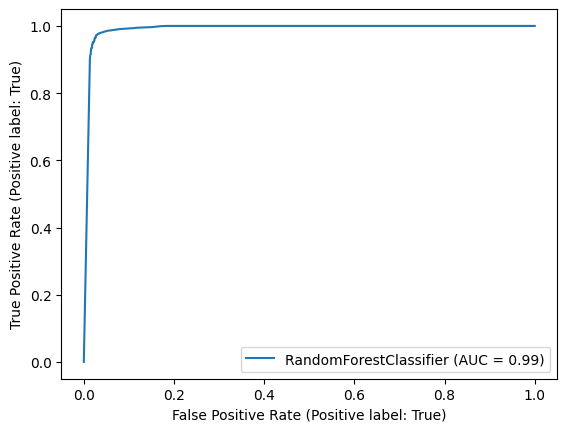

In [19]:
RocCurveDisplay.from_estimator(classifier, X_test, y_test)